In [1118]:
# delete packages and install from requirements.txt
# !pip uninstall -y -r requirements.txt
!pip install -r requirements.txt
!pip freeze > requirements.txt

You should consider upgrading via the 'C:\Users\mat_h\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [1119]:
import pandas as pd
import numpy as np
import ta
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import joblib # Para salvar scalers e modelos sklearn

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import xgboost as xgb

In [1120]:
def download_stock_data(ticker, start_date, end_date):
    """
    Downloads historical stock data for a given ticker symbol between specified dates.

    Parameters:
    ticker (str): The stock ticker symbol.
    start_date (str): The start date in 'YYYY-MM-DD' format.
    end_date (str): The end date in 'YYYY-MM-DD' format.

    Returns:
    pd.DataFrame: A DataFrame containing the stock data.
    """
    stock = yf.download(ticker, start=start_date, end=end_date)
    data = stock.xs(ticker, level="Ticker", axis=1)
    if data.empty:
        raise ValueError(f"No data found for ticker {ticker} between {start_date} and {end_date}.")
    return data

In [1121]:
df = download_stock_data('PETR4.SA', '2000-01-01', '2025-01-01')
df.head()

C:\Users\mat_h\AppData\Local\Temp\ipykernel_24148\3599526879.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,1.364428,1.364428,1.364428,1.364428,35389440000
2000-01-04,1.288950,1.288950,1.288950,1.288950,28861440000
2000-01-05,1.275944,1.275944,1.275944,1.275944,43033600000
2000-01-06,1.271531,1.271531,1.271531,1.271531,34055680000
2000-01-07,1.277337,1.277337,1.277337,1.277337,20912640000


## Preenchendo valores nulos

In [1122]:
df_filled = df.copy()
df_filled['Close'] = df_filled['Close'].fillna(method='ffill')
df_filled['Volume'] = df_filled['Volume'].fillna(method='ffill')
df_filled['High'] = df_filled['High'].fillna(method='ffill')
df_filled['Low'] = df_filled['Low'].fillna(method='ffill')

C:\Users\mat_h\AppData\Local\Temp\ipykernel_24148\4096485336.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled['Close'] = df_filled['Close'].fillna(method='ffill')
C:\Users\mat_h\AppData\Local\Temp\ipykernel_24148\4096485336.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled['Volume'] = df_filled['Volume'].fillna(method='ffill')
C:\Users\mat_h\AppData\Local\Temp\ipykernel_24148\4096485336.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled['High'] = df_filled['High'].fillna(method='ffill')
C:\Users\mat_h\AppData\Local\Temp\ipykernel_24148\4096485336.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_

## Feature engenniring 

### Momentum 

In [1123]:
df['RSI'] = ta.momentum.rsi(df_filled['Close'], window=14) # Relative Strength Index
df['MACD'] = ta.trend.macd(df_filled['Close']) # Moving Average Convergence Divergence (também mede tendência)

### Tendência

In [1124]:
df['SMA_10'] = ta.trend.sma_indicator(df_filled['Close'], window=10) # Simple Moving Average
df['SMA_50'] = ta.trend.sma_indicator(df_filled['Close'], window=50) # Simple Moving Average
df['SMA_200'] = ta.trend.sma_indicator(df_filled['Close'], window=200) # Simple Moving Average
df['EMA_10'] = ta.trend.ema_indicator(df_filled['Close'], window=10) # Exponential Moving Average
df['EMA_50'] = ta.trend.ema_indicator(df_filled['Close'], window=50) # Exponential Moving Average
df['EMA_200'] = ta.trend.ema_indicator(df_filled['Close'], window=200) # Exponential Moving Average

### Volatilidade

In [1125]:
df['ART'] = ta.volatility.average_true_range(df_filled['High'], df_filled['Low'], df_filled['Close'], window=14) # Average True Range
df['BB_High'] = ta.volatility.bollinger_hband(df_filled['Close'], window=20, window_dev=2) # Banda de boolinger (alta)
df['BB_MM'] = ta.volatility.bollinger_mavg(df_filled['Close'], window=20) # Banda de boolinger (Média-movel)
df['BB_Lower'] = ta.volatility.bollinger_lband(df_filled['Close'], window=20, window_dev=2) # Banda de boolinger (Baixa)
df['BB_Width'] = ta.volatility.bollinger_wband(df_filled['Close'], window=20, window_dev=2) # Largura das Bandas de Bollinger

### Volume

In [1126]:

df['Volume_OBV'] = ta.volume.on_balance_volume(df_filled['Close'], df_filled['Volume']) # On-Balance Volume

In [1127]:
df = df.dropna()
df.tail()

Price,Close,High,Low,Open,Volume,RSI,MACD,SMA_10,SMA_50,SMA_200,EMA_10,EMA_50,EMA_200,ART,BB_High,BB_MM,BB_Lower,BB_Width,Volume_OBV
Date,,,,,,,,,,,,,,,,,,,
2024-12-20,34.918674,35.392469,34.786013,35.212429,59277400,45.608795,0.320818,36.027459,34.376883,33.255583,35.675283,34.831140,32.926078,0.693961,36.879752,35.847290,34.814828,5.760336,298492850117
2024-12-23,34.928150,35.108191,34.795488,35.060812,43785600,45.716660,0.236561,35.871174,34.389189,33.287118,35.539441,34.834944,32.945999,0.666729,36.915111,35.808337,34.701563,6.181655,298536635717
2024-12-26,33.895279,34.113224,33.734187,33.762617,22920700,37.083743,0.085458,35.597932,34.381385,33.308792,35.240502,34.798095,32.955445,0.704388,37.106165,35.720018,34.333871,7.761175,298513715017
2024-12-27,33.791046,34.113227,33.743667,34.113227,24167200,36.338004,-0.042216,35.277812,34.369855,33.331711,34.976965,34.758603,32.963759,0.680472,37.254068,35.632867,34.011666,9.099469,298489547817
2024-12-30,34.293266,34.463833,33.895280,33.904755,22355600,42.353242,-0.101701,35.074080,34.374021,33.357783,34.852656,34.740354,32.976988,0.679923,37.302700,35.589054,33.875409,9.630183,298511903417


## Preparando os dados para treinamento

In [1128]:
target = df['Close']
features = df[['High','Low','Open', 'Volume','RSI','MACD','SMA_10','SMA_50','SMA_200','EMA_10','EMA_50','EMA_200','ART','BB_High','BB_MM','BB_Lower','BB_Width','Volume_OBV']]
X_ns = features.values
y_ns = target.values

In [1129]:
train_split_ratio_ns = 0.8
train_size_ns = int(len(X_ns) * train_split_ratio_ns)

X_train_ns, X_test_ns = X_ns[:train_size_ns], X_ns[train_size_ns:]
y_train_ns, y_test_ns = y_ns[:train_size_ns], y_ns[train_size_ns:]

### Escalonamento

In [1130]:
feature_scaler_ns = MinMaxScaler(feature_range=(0, 1))
X_train_scaled_ns = feature_scaler_ns.fit_transform(X_train_ns) # Fit e transform em treino
X_test_scaled_ns = feature_scaler_ns.transform(X_test_ns) # Apenas transform em teste

In [1131]:
target_scaler_ns = MinMaxScaler(feature_range=(0, 1))
y_train_scaled_ns = target_scaler_ns.fit_transform(y_train_ns.reshape(-1, 1)) # Fit e transform em treino (reshape para 2D)
y_test_scaled_ns = target_scaler_ns.transform(y_test_ns.reshape(-1, 1)) # Apenas transform em teste

In [1132]:
model_lr = LinearRegression()

# Treinar o modelo
model_lr.fit(X_train_scaled_ns, y_train_scaled_ns)

# Fazer previsões
predictions_scaled_lr = model_lr.predict(X_test_scaled_ns)


In [1133]:
# Inverter o escalonamento das previsões para a escala original
predictions_lr = target_scaler_ns.inverse_transform(predictions_scaled_lr.reshape(-1, 1))
y_test_original_lr = target_scaler_ns.inverse_transform(y_test_scaled_ns)

In [1134]:
# Avaliar o modelo
rmse_lr = np.sqrt(mean_squared_error(y_test_original_lr, predictions_lr))
mae_lr = mean_absolute_error(y_test_original_lr, predictions_lr)
r2_lr = r2_score(y_test_original_lr, predictions_lr)

print(f"RMSE (Regressão Linear): {rmse_lr:.4f}")
print(f"MAE (Regressão Linear): {mae_lr:.4f}")
print(f"R2 Score (Regressão Linear): {r2_lr:.4f}")

RMSE (Regressão Linear): 0.1812
MAE (Regressão Linear): 0.1276
R2 Score (Regressão Linear): 0.9997


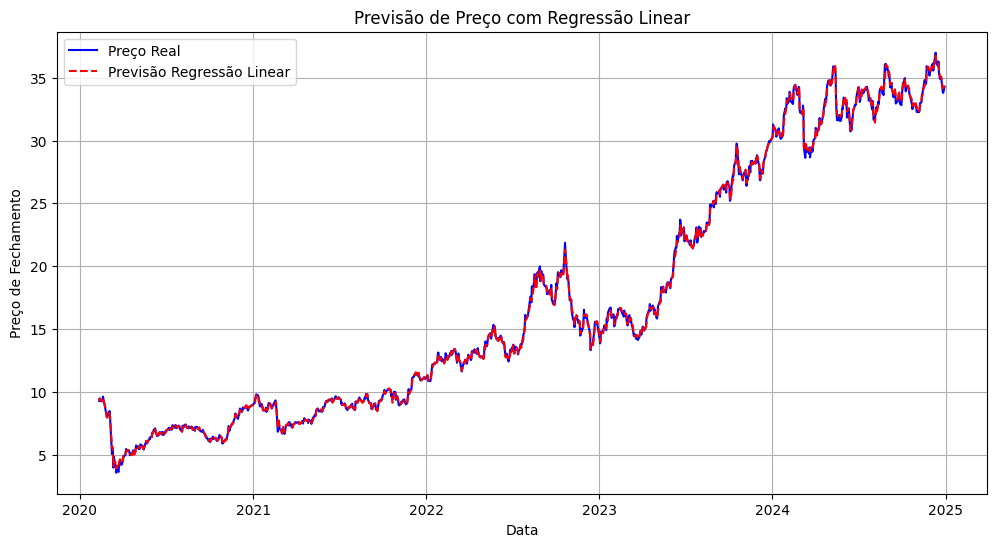

In [1135]:
# Plotar resultados
plt.figure(figsize=(12, 6))
plt.plot(df.index[train_size_ns + (window_size if 'rnn' in locals() else 0):], y_test_original_lr, label='Preço Real', color='blue')
plt.plot(df.index[train_size_ns + (window_size if 'rnn' in locals() else 0):], predictions_lr, label='Previsão Regressão Linear', color='red', linestyle='--')
plt.title('Previsão de Preço com Regressão Linear')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

In [1136]:
joblib.dump(model_lr, 'model_lr.pkl')
joblib.dump(feature_scaler_ns, 'feature_scaler_ns.pkl')
joblib.dump(target_scaler_ns, 'target_scaler_ns.pkl')
print("Modelo de Regressão Linear e scalers salvos.")

Modelo de Regressão Linear e scalers salvos.


### Arvore de decisão

In [1137]:
model_dt = DecisionTreeRegressor(random_state=42) # random_state para reprodutibilidade

In [1138]:
# Treinar o modelo (usando dados escalados, embora não estritamente necessário para DT)
model_dt.fit(X_train_scaled_ns, y_train_scaled_ns)

# Fazer previsões
predictions_scaled_dt = model_dt.predict(X_test_scaled_ns)

# Inverter o escalonamento
predictions_dt = target_scaler_ns.inverse_transform(predictions_scaled_dt.reshape(-1, 1))
y_test_original_dt = target_scaler_ns.inverse_transform(y_test_scaled_ns)


In [1139]:
rmse_dt = np.sqrt(mean_squared_error(y_test_original_dt, predictions_dt))
mae_dt = mean_absolute_error(y_test_original_dt, predictions_dt)
r2_dt = r2_score(y_test_original_dt, predictions_dt)

print(f"RMSE (Árvore de Decisão): {rmse_dt:.4f}")
print(f"MAE (Árvore de Decisão): {mae_dt:.4f}")
print(f"R2 Score (Árvore de Decisão): {r2_dt:.4f}")

RMSE (Árvore de Decisão): 10.3503
MAE (Árvore de Decisão): 6.4214
R2 Score (Árvore de Decisão): -0.0939


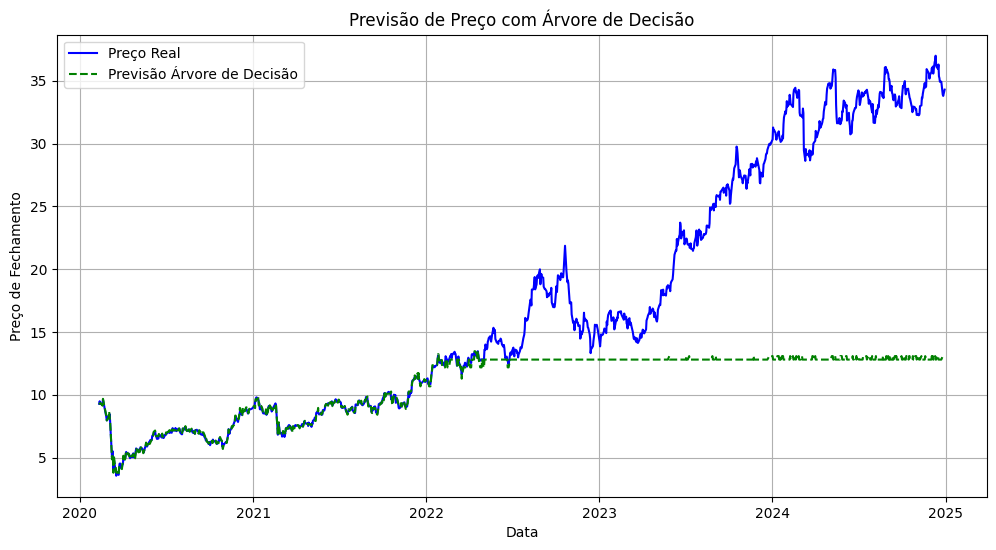

In [1140]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[train_size_ns + (window_size if 'rnn' in locals() else 0):], y_test_original_dt, label='Preço Real', color='blue')
plt.plot(df.index[train_size_ns + (window_size if 'rnn' in locals() else 0):], predictions_dt, label='Previsão Árvore de Decisão', color='green', linestyle='--')
plt.title('Previsão de Preço com Árvore de Decisão')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

### Random Forest

In [ ]:
model_rf = RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs=-1, max_depth=100)


In [1142]:
model_rf.fit(X_train_scaled_ns, y_train_scaled_ns.ravel()) # .ravel() para transformar y em 1D


RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=42)

In [1143]:
predictions_scaled_rf = model_rf.predict(X_test_scaled_ns)


In [1144]:
predictions_rf = target_scaler_ns.inverse_transform(predictions_scaled_rf.reshape(-1, 1))
y_test_original_rf = target_scaler_ns.inverse_transform(y_test_scaled_ns)


In [1145]:
rmse_rf = np.sqrt(mean_squared_error(y_test_original_rf, predictions_rf))
mae_rf = mean_absolute_error(y_test_original_rf, predictions_rf)
r2_rf = r2_score(y_test_original_rf, predictions_rf)

print(f"RMSE (RandomForest): {rmse_rf:.4f}")
print(f"MAE (RandomForest): {mae_rf:.4f}")
print(f"R2 Score (RandomForest): {r2_rf:.4f}")

RMSE (RandomForest): 10.4852
MAE (RandomForest): 6.5221
R2 Score (RandomForest): -0.1226


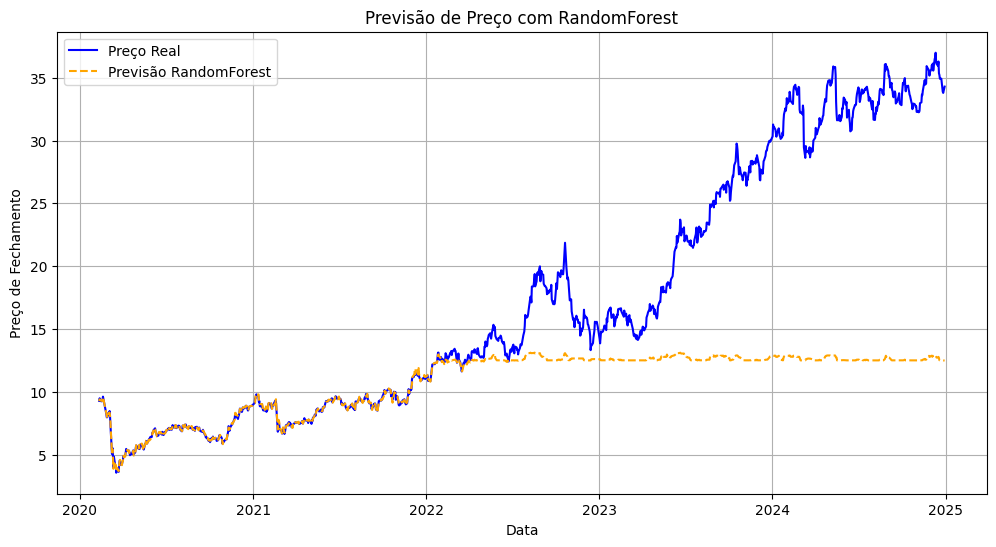

In [1146]:
plt.figure(figsize=(12, 6))
plot_start_index = len(df) - len(y_test_original_rf) # Índice de início do test set no df original
plt.plot(df.index[plot_start_index:], y_test_original_rf, label='Preço Real', color='blue')
plt.plot(df.index[plot_start_index:], predictions_rf, label='Previsão RandomForest', color='orange', linestyle='--')
plt.title('Previsão de Preço com RandomForest')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

### XGBoost para tentar adequar a variância do mercado

In [1147]:
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,             # 100-1000
    learning_rate=0.1,           # 0.01-0.3
    max_depth=5,                  # 3-10
    subsample=0.9,                # 0.6-0.9
    colsample_bytree=0.9,         # 0.6-0.9
    random_state=42,
    n_jobs=-1
)


In [1148]:
model_xgb.fit(X_train_scaled_ns, y_train_scaled_ns.ravel())


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [1149]:
predictions_scaled_xgb = model_xgb.predict(X_test_scaled_ns)


In [1150]:
predictions_xgb = target_scaler_ns.inverse_transform(predictions_scaled_xgb.reshape(-1, 1))
y_test_original_xgb = target_scaler_ns.inverse_transform(y_test_scaled_ns)


In [1151]:
rmse_xgb = np.sqrt(mean_squared_error(y_test_original_xgb, predictions_xgb))
mae_xgb = mean_absolute_error(y_test_original_xgb, predictions_xgb)
r2_xgb = r2_score(y_test_original_xgb, predictions_xgb)

print(f"RMSE (XGBoost): {rmse_xgb:.4f}")
print(f"MAE (XGBoost): {mae_xgb:.4f}")
print(f"R2 Score (XGBoost): {r2_xgb:.4f}")

RMSE (XGBoost): 10.6099
MAE (XGBoost): 6.6365
R2 Score (XGBoost): -0.1494


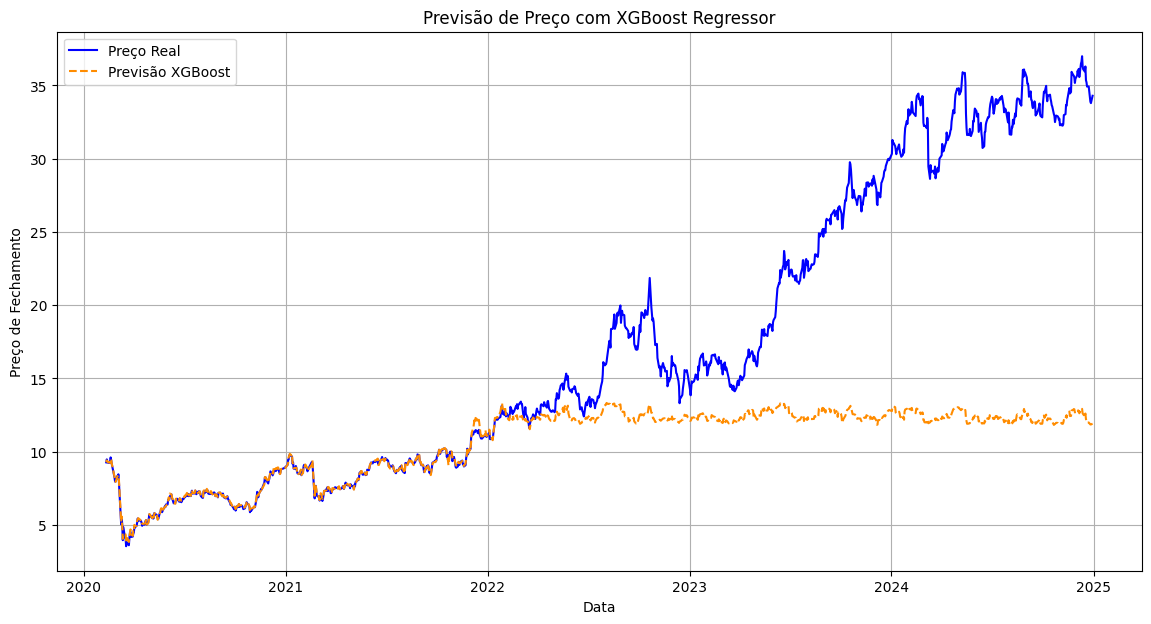

In [1152]:
plt.figure(figsize=(14, 7))
plot_start_index_xgb = len(df) - len(y_test_original_xgb)
plt.plot(df.index[plot_start_index_xgb:], y_test_original_xgb, label='Preço Real', color='blue')
plt.plot(df.index[plot_start_index_xgb:], predictions_xgb, label='Previsão XGBoost', color='darkorange', linestyle='--')
plt.title('Previsão de Preço com XGBoost Regressor')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

### RNN - LSTM

In [1153]:
features_cols = [
    'High','Low','Open', 'Volume','RSI','MACD','SMA_10','SMA_50','SMA_200','EMA_10','EMA_50','EMA_200','ART','BB_High','BB_MM','BB_Lower','BB_Width','Volume_OBV'
]
target_col = 'Close'

In [ ]:
window_size = 30 # Usaremos 30 dias de dados históricos
def create_sequences(data, window_size, features_cols, target_col):
    X, y = [], []
    for i in range(len(data) - window_size):
        window_features = data.iloc[i : (i + window_size)][features_cols].values
        # O valor alvo é o 'Target_Close' do último dia da janela
        target_value = data.iloc[i + window_size - 1][target_col]
        X.append(window_features)
        y.append(target_value)
    return np.array(X), np.array(y)

In [1155]:
X_rnn_raw, y_rnn_raw = create_sequences(df, window_size, features_cols, target_col)


In [1156]:
train_split_ratio_rnn = 0.8
train_size_rnn = int(len(X_rnn_raw) * train_split_ratio_rnn)

In [1157]:
X_train_rnn_raw, X_test_rnn_raw = X_rnn_raw[:train_size_rnn], X_rnn_raw[train_size_rnn:]
y_train_rnn_raw, y_test_rnn_raw = y_rnn_raw[:train_size_rnn], y_rnn_raw[train_size_rnn:]


In [1158]:
feature_scaler_rnn = MinMaxScaler(feature_range=(0, 1))
X_train_flat_rnn = X_train_rnn_raw.reshape(-1, X_train_rnn_raw.shape[-1])
X_test_flat_rnn = X_test_rnn_raw.reshape(-1, X_test_rnn_raw.shape[-1])


feature_scaler_rnn.fit(X_train_flat_rnn)
X_train_scaled_rnn = feature_scaler_rnn.transform(X_train_flat_rnn).reshape(X_train_rnn_raw.shape)
X_test_scaled_rnn = feature_scaler_rnn.transform(X_test_flat_rnn).reshape(X_test_rnn_raw.shape)

target_scaler_rnn = MinMaxScaler(feature_range=(0, 1))
y_train_scaled_rnn = target_scaler_rnn.fit_transform(y_train_rnn_raw.reshape(-1, 1))
y_test_scaled_rnn = target_scaler_rnn.transform(y_test_rnn_raw.reshape(-1, 1))


In [1159]:
model_rnn = Sequential([
    LSTM(units=200, return_sequences=True, input_shape=(window_size, X_train_scaled_rnn.shape[2])),
    Dropout(0.3),
    LSTM(units=200, return_sequences=True), # Camada intermediária
    Dropout(0.3),
    LSTM(units=200, return_sequences=False), # Última camada LSTM
    Dropout(0.3),
    Dense(units=1)
])

c:\Users\mat_h\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [1160]:
model_rnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])


In [1161]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)


In [1162]:
history = model_rnn.fit(
    X_train_scaled_rnn, y_train_scaled_rnn,
    epochs=100, # Número de épocas, ajuste conforme necessário
    batch_size=31, # Tamanho do batch
    validation_data=(X_test_scaled_rnn, y_test_scaled_rnn), # Usar dados de teste como validação
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 30s 177ms/step - loss: 0.0136 - mean_absolute_error: 0.0669 - val_loss: 0.1903 - val_mean_absolute_error: 0.2725 - learning_rate: 0.0010
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - loss: 0.0022 - mean_absolute_error: 0.0339 - val_loss: 0.2225 - val_mean_absolute_error: 0.2965 - learning_rate: 0.0010
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 155ms/step - loss: 0.0014 - mean_absolute_error: 0.0269 - val_loss: 0.1936 - val_mean_absolute_error: 0.2851 - learning_rate: 0.0010
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 158ms/step - loss: 0.0014 - mean_absolute_error: 0.0268 - val_loss: 0.1736 - val_mean_absolute_error: 0.2609 - learning_rate: 0.0010
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step - loss: 0.0013 - mean_absolute_error: 0.0258 - val_loss: 0.1302 - val_mean_absolute_error: 0.2280 - learning_rate: 0.0010
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 157ms/step - loss: 0.0013 - mean_absolute_error: 0.0264 - val_los

In [1163]:
predictions_scaled_rnn = model_rnn.predict(X_test_scaled_rnn)

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step


In [1164]:
predictions_rnn = target_scaler_rnn.inverse_transform(predictions_scaled_rnn)
y_test_original_rnn = target_scaler_rnn.inverse_transform(y_test_scaled_rnn)

In [1165]:
rmse_rnn = np.sqrt(mean_squared_error(y_test_original_rnn, predictions_rnn))
mae_rnn = mean_absolute_error(y_test_original_rnn, predictions_rnn)
r2_rnn = r2_score(y_test_original_rnn, predictions_rnn)

print(f"RMSE (LSTM): {rmse_rnn:.4f}")
print(f"MAE (LSTM): {mae_rnn:.4f}")
print(f"R2 Score (LSTM): {r2_rnn:.4f}")

RMSE (LSTM): 5.2044
MAE (LSTM): 3.1767
R2 Score (LSTM): 0.7234


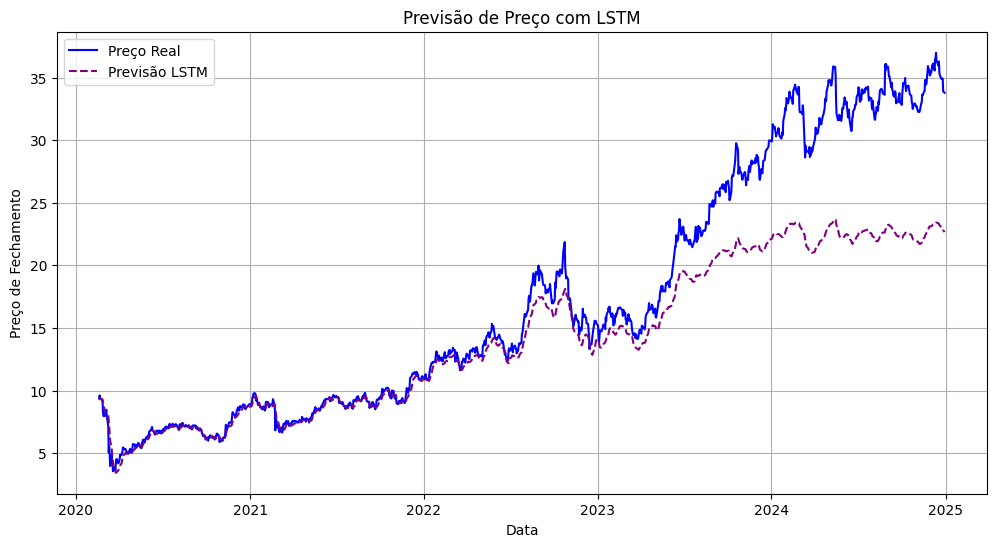

In [1166]:
start_idx_plot_rnn = len(df) - len(y_test_original_rnn)
plt.figure(figsize=(12, 6))
plt.plot(df.index[start_idx_plot_rnn:], y_test_original_rnn, label='Preço Real', color='blue')
plt.plot(df.index[start_idx_plot_rnn:], predictions_rnn, label='Previsão LSTM', color='purple', linestyle='--')
plt.title('Previsão de Preço com LSTM')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

Regressão Linear:
  RMSE: 0.1812
  MAE: 0.1276
  R2 Score: 0.9997



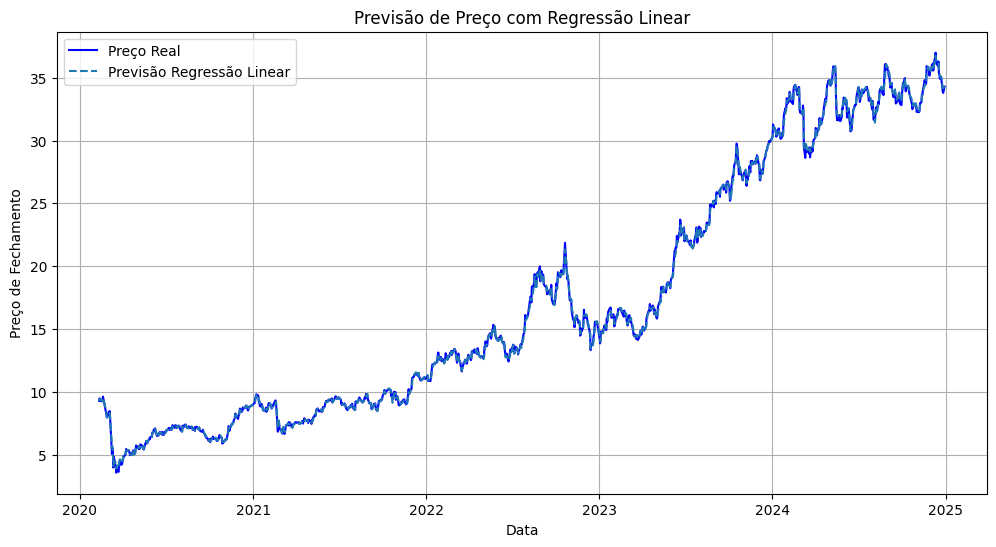

Árvore de Decisão:
  RMSE: 10.3503
  MAE: 6.4214
  R2 Score: -0.0939



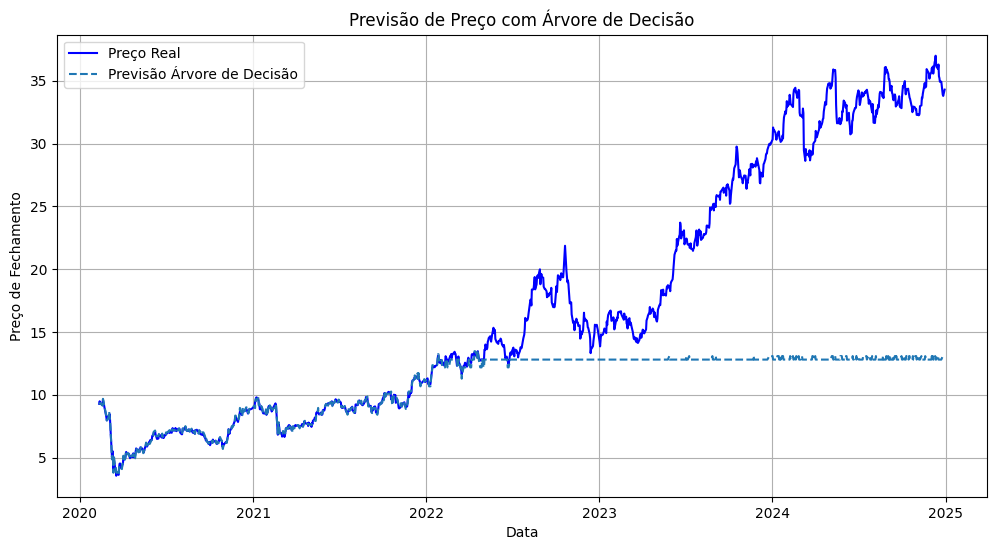

Random Forest:
  RMSE: 10.4852
  MAE: 6.5221
  R2 Score: -0.1226



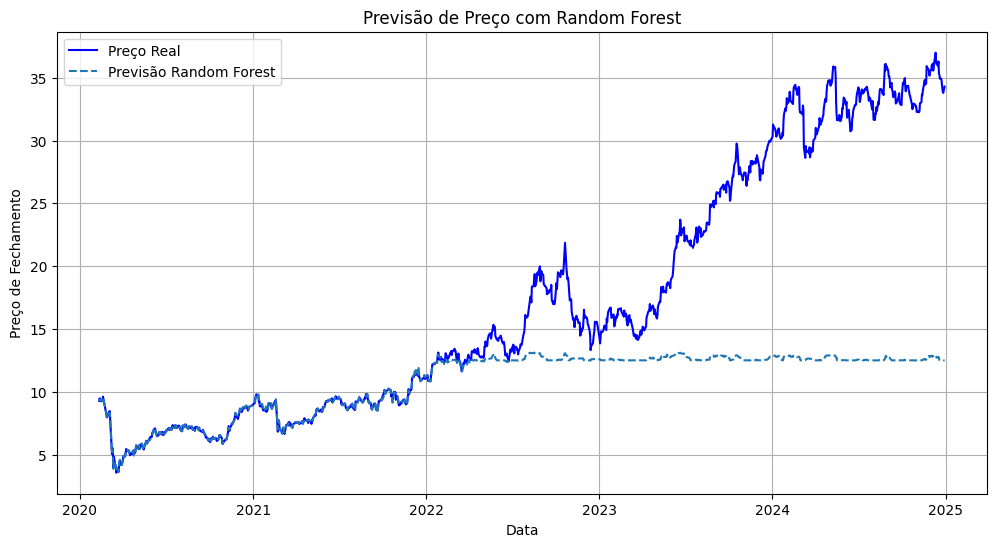

XGBoost:
  RMSE: 10.6099
  MAE: 6.6365
  R2 Score: -0.1494



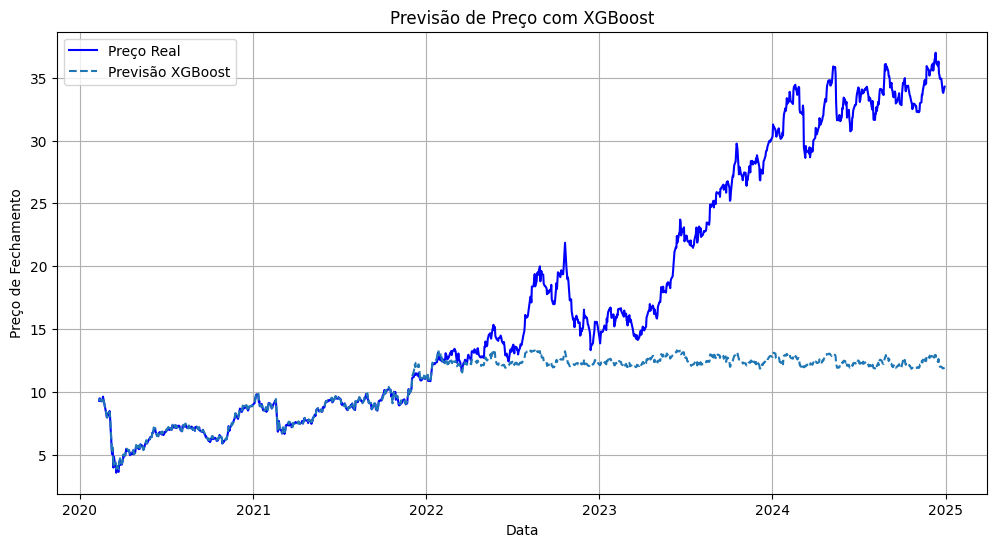

LSTM:
  RMSE: 5.2044
  MAE: 3.1767
  R2 Score: 0.7234



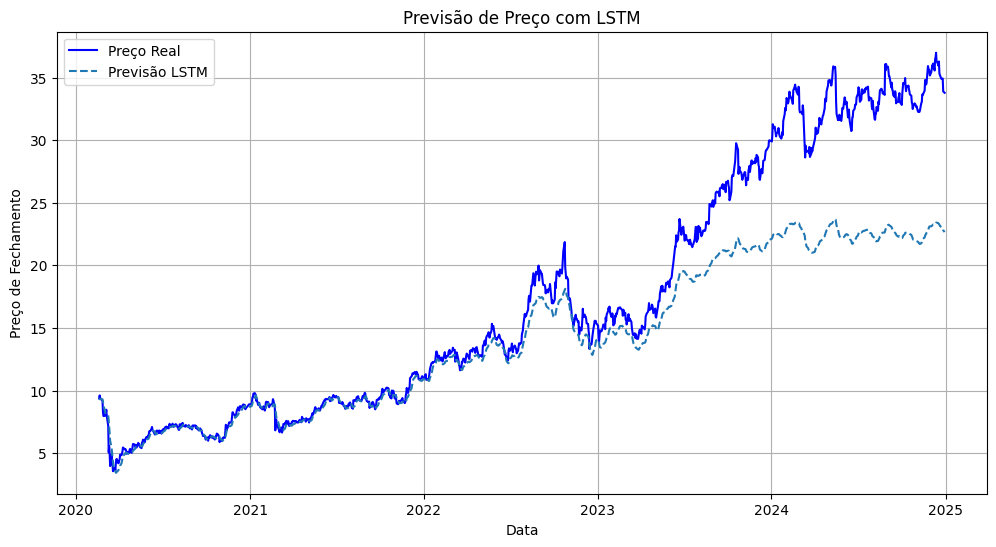

In [1167]:
# comparar todos os modelos
models = {
    'Regressão Linear': (model_lr, predictions_lr, y_test_original_lr),
    'Árvore de Decisão': (model_dt, predictions_dt, y_test_original_dt),
    'Random Forest': (model_rf, predictions_rf, y_test_original_rf),
    'XGBoost': (model_xgb, predictions_xgb, y_test_original_xgb),
    'LSTM': (model_rnn, predictions_rnn, y_test_original_rnn)
}
for model_name, (model, predictions, y_test_original) in models.items():
    rmse = np.sqrt(mean_squared_error(y_test_original, predictions))
    mae = mean_absolute_error(y_test_original, predictions)
    r2 = r2_score(y_test_original, predictions)
    
    print(f"{model_name}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R2 Score: {r2:.4f}\n")
    
    plt.figure(figsize=(12, 6))
    start_idx_plot = len(df) - len(y_test_original)
    plt.plot(df.index[start_idx_plot:], y_test_original, label='Preço Real', color='blue')
    plt.plot(df.index[start_idx_plot:], predictions, label=f'Previsão {model_name}', linestyle='--')
    plt.title(f'Previsão de Preço com {model_name}')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')
    plt.legend()
    plt.grid(True)
    plt.show()


In [1168]:
features_cols = [
    'High','Low','Open', 'Volume','RSI','MACD','SMA_10','SMA_50','SMA_200','EMA_10','EMA_50','EMA_200','ART','BB_High','BB_MM','BB_Lower','BB_Width','Volume_OBV'
]
target_col = 'Close'
# --- NOVA FUNÇÃO create_sequences para Múltiplos Passos ---
def create_sequences_multi_step(data_df, window_size, forecast_horizon, features_cols, target_col_name):
    X, y = [], []
    # Precisamos de dados suficientes para a janela e para o horizonte de previsão
    for i in range(len(data_df) - window_size - forecast_horizon + 1):
        # Features: a janela de dados até o dia 'i + window_size - 1'
        window_features = data_df.iloc[i : (i + window_size)][features_cols].values

        # Target: os próximos 'forecast_horizon' valores da coluna alvo,
        # começando DO DIA SEGUINTE ao final da janela de features
        target_sequence = data_df.iloc[(i + window_size) : (i + window_size + forecast_horizon)][target_col_name].values

        X.append(window_features)
        y.append(target_sequence)
    return np.array(X), np.array(y)

# Parâmetros para a criação das sequências
window_size = 30 # Usaremos 30 dias de dados históricos como entrada
forecast_horizon = 7 # Queremos prever os próximos 7 dias

In [1169]:
X_raw, y_raw = create_sequences_multi_step(df, window_size, forecast_horizon, features_cols, target_col)


In [1170]:
# --- 2. Divisão Cronológica em Treino e Teste ---
train_split_ratio = 0.8
train_size = int(len(X_raw) * train_split_ratio)

X_train_raw, X_test_raw = X_raw[:train_size], X_raw[train_size:]
y_train_raw, y_test_raw = y_raw[:train_size], y_raw[train_size:]

print(f"\nShapes para treino/teste (RNN multi-step):")
print(f"X_train_raw: {X_train_raw.shape}, y_train_raw: {y_train_raw.shape}")
print(f"X_test_raw: {X_test_raw.shape}, y_test_raw: {y_test_raw.shape}")

# --- 3. Escalonamento dos Dados ---

# Scaler para Features (X) - Igual ao modelo de um passo
X_train_flat = X_train_raw.reshape(-1, X_train_raw.shape[-1])
X_test_flat = X_test_raw.reshape(-1, X_test_raw.shape[-1])

feature_scaler = MinMaxScaler(feature_range=(0, 1))
feature_scaler.fit(X_train_flat)

X_train_scaled = feature_scaler.transform(X_train_flat).reshape(X_train_raw.shape)
X_test_scaled = feature_scaler.transform(X_test_flat).reshape(X_test_raw.shape)

# Scaler para o Alvo (y) - Agora y_raw já é 2D (samples, forecast_horizon)
# O scaler vai ajustar cada uma das 'forecast_horizon' colunas de target.
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(y_train_raw) # Ajustar diretamente no y_train_raw (2D)

y_train_scaled = target_scaler.transform(y_train_raw)
y_test_scaled = target_scaler.transform(y_test_raw)

print(f"\nShapes após escalonamento (RNN multi-step):")
print(f"X_train_scaled: {X_train_scaled.shape}, y_train_scaled: {y_train_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}, y_test_scaled: {y_test_scaled.shape}")


Shapes para treino/teste (RNN multi-step):
X_train_raw: (4833, 30, 18), y_train_raw: (4833, 7)
X_test_raw: (1209, 30, 18), y_test_raw: (1209, 7)

Shapes após escalonamento (RNN multi-step):
X_train_scaled: (4833, 30, 18), y_train_scaled: (4833, 7)
X_test_scaled: (1209, 30, 18), y_test_scaled: (1209, 7)


In [ ]:

# Definir a arquitetura do modelo (reaproveitando melhorias anteriores)
model_rnn_multi_step = Sequential([
    Bidirectional(LSTM(units=100, return_sequences=True,
                       input_shape=(window_size, X_train_scaled.shape[2]))),
    Dropout(0.3),

    LSTM(units=100, return_sequences=False), # Última camada LSTM, não retorna sequência para a Dense
    Dropout(0.3),

    # Camada Densa de Saída: AGORA com 'forecast_horizon' unidades
    Dense(units=forecast_horizon) # <--- AQUI ESTÁ A MUDANÇA PRINCIPAL!
])

# Compilar o modelo
model_rnn_multi_step.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model_rnn_multi_step.summary()

# --- 5. Treinamento do Modelo ---
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001, verbose=1
)

print("\n--- Treinando Modelo LSTM Multi-Passos ---")
history_multi_step = model_rnn_multi_step.fit(
    X_train_scaled, y_train_scaled,
    epochs=100, # Ou mais, EarlyStopping vai parar
    batch_size=32,
    validation_data=(X_test_scaled, y_test_scaled),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

predictions_scaled_multi_step = model_rnn_multi_step.predict(X_test_scaled)

predictions_multi_step = target_scaler.inverse_transform(predictions_scaled_multi_step)
y_test_original_multi_step = target_scaler.inverse_transform(y_test_scaled)



--- Avaliação para Previsão de 7 Dias ---
Dia D+1: RMSE=5.5878, MAE=3.4261
Dia D+2: RMSE=5.6567, MAE=3.5198
Dia D+3: RMSE=5.2757, MAE=3.2878
Dia D+4: RMSE=5.6239, MAE=3.5480
Dia D+5: RMSE=5.8091, MAE=3.6803
Dia D+6: RMSE=5.6602, MAE=3.6062
Dia D+7: RMSE=5.8330, MAE=3.7427

Médias para o Horizonte de 7 Dias:
RMSE Médio: 5.6377
MAE Médio: 3.5444
R2 Score Médio: 0.6743


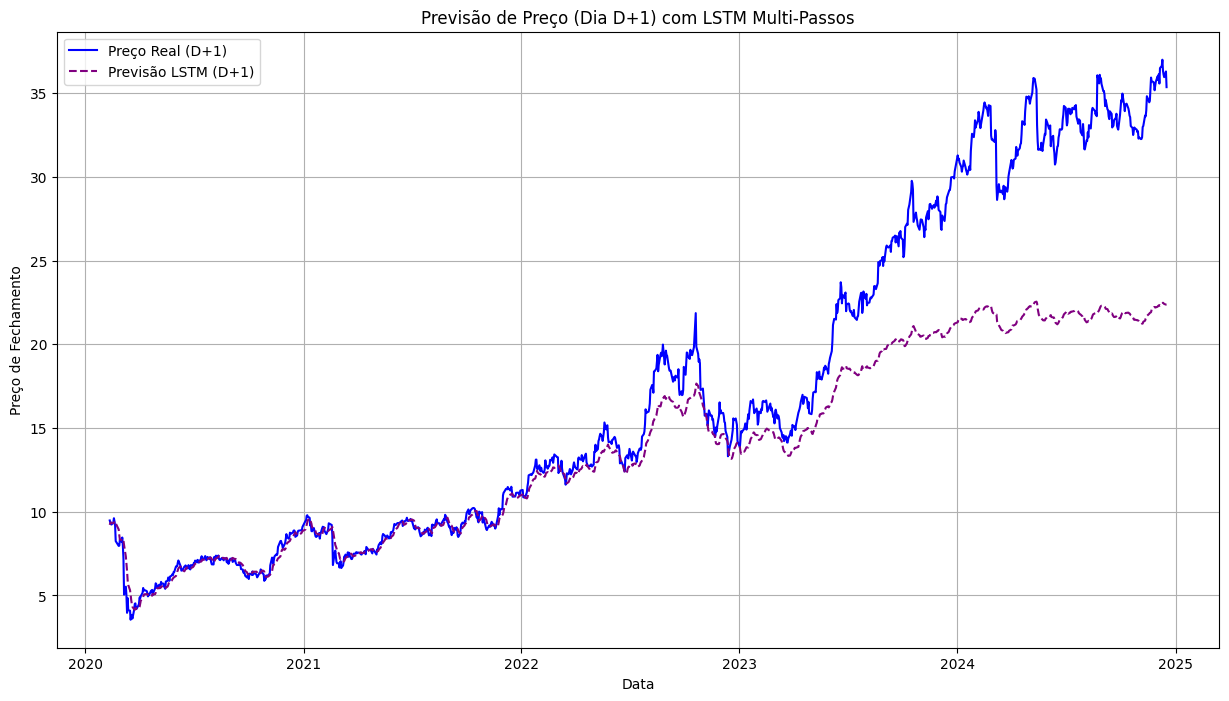

In [1174]:
print(f"\n--- Avaliação para Previsão de {forecast_horizon} Dias ---")
for i in range(forecast_horizon):
    rmse_day_i = np.sqrt(mean_squared_error(y_test_original_multi_step[:, i], predictions_multi_step[:, i]))
    mae_day_i = mean_absolute_error(y_test_original_multi_step[:, i], predictions_multi_step[:, i])
    print(f"Dia D+{i+1}: RMSE={rmse_day_i:.4f}, MAE={mae_day_i:.4f}")

rmse_avg = np.sqrt(mean_squared_error(y_test_original_multi_step.flatten(), predictions_multi_step.flatten()))
mae_avg = mean_absolute_error(y_test_original_multi_step.flatten(), predictions_multi_step.flatten())
r2_avg = r2_score(y_test_original_multi_step.flatten(), predictions_multi_step.flatten())
print(f"\nMédias para o Horizonte de {forecast_horizon} Dias:")
print(f"RMSE Médio: {rmse_avg:.4f}")
print(f"MAE Médio: {mae_avg:.4f}")
print(f"R2 Score Médio: {r2_avg:.4f}")

plt.figure(figsize=(15, 8))
plt.plot(df.index[train_size + window_size - 1 : train_size + window_size - 1 + len(y_test_original_multi_step)],
         y_test_original_multi_step[:, 0], label='Preço Real (D+1)', color='blue')
plt.plot(df.index[train_size + window_size - 1 : train_size + window_size - 1 + len(y_test_original_multi_step)],
         predictions_multi_step[:, 0], label='Previsão LSTM (D+1)', color='purple', linestyle='--')

plt.title(f'Previsão de Preço (Dia D+1) com LSTM Multi-Passos')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()


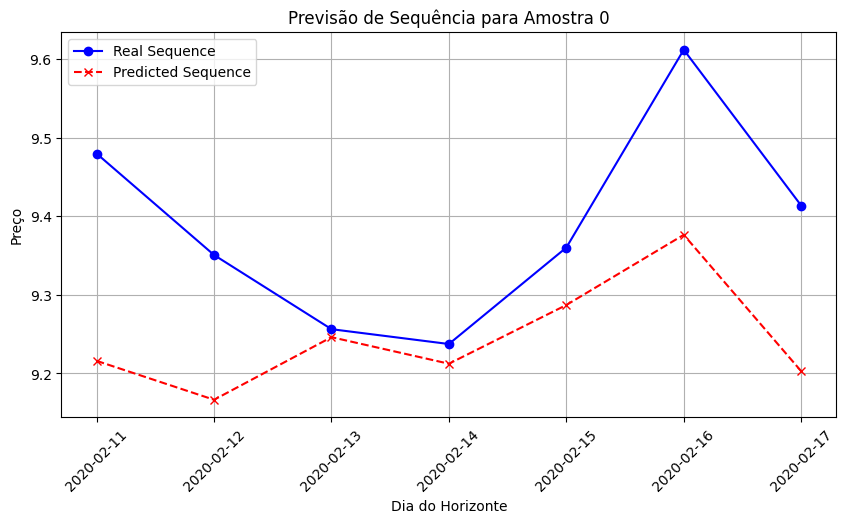

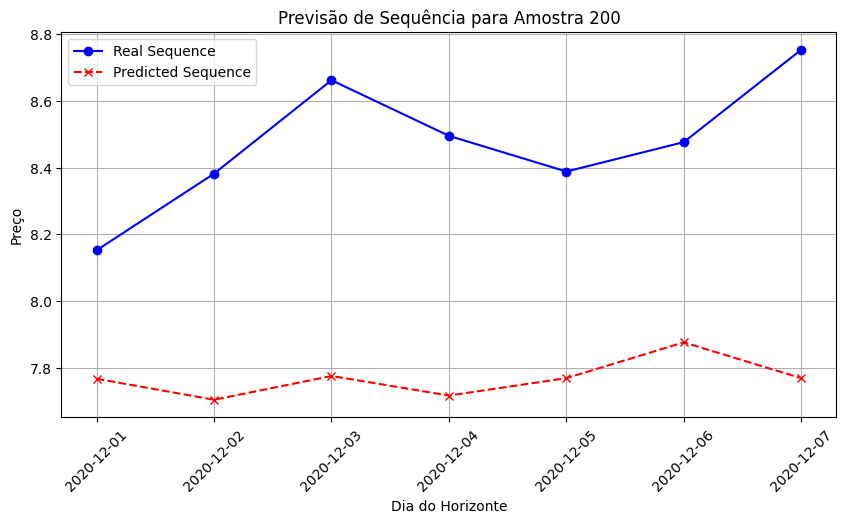

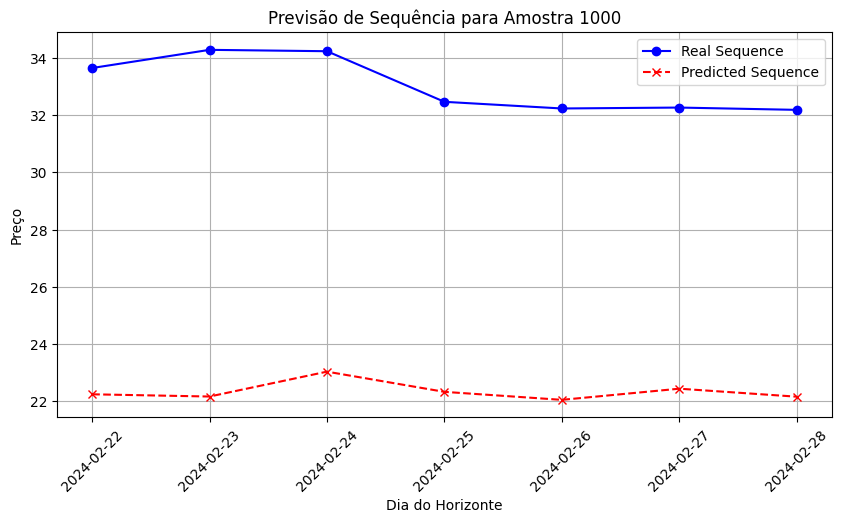


Modelo LSTM multi-passos e scalers salvos.


In [ ]:
sample_indices = [0, 200, 1000] # Escolha alguns índices do seu test set
for idx in sample_indices:
    plt.figure(figsize=(10, 5))
    actual_sequence = y_test_original_multi_step[idx, :]
    predicted_sequence = predictions_multi_step[idx, :]
    
    start_date_for_plot = df.index[train_size + window_size - 1 + idx] 
    future_dates = start_date_for_plot + pd.to_timedelta(np.arange(forecast_horizon), unit='D')
    
    plt.plot(future_dates, actual_sequence, label='Real Sequence', color='blue', marker='o')
    plt.plot(future_dates, predicted_sequence, label='Predicted Sequence', color='red', linestyle='--', marker='x')
    plt.title(f'Previsão de Sequência para Amostra {idx}')
    plt.xlabel('Dia do Horizonte')
    plt.ylabel('Preço')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()